# Geodesic Demo

First, we import the necessary modules.

In [3]:
%load_ext autoreload
%autoreload 2

from fadge import GRRT
from jax   import numpy as np

from matplotlib import pyplot as plt
from itertools  import product

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We then instasize `PRay` into an object

In [4]:
grrt = GRRT(aspin=0.9375, atol=1e-3, rtol=0, names={'ind':'lambda'})

Radius of outer event horizon: 1.3479853


To setup the initial conditions, we first set the camera location, and then specify the image.

In [6]:
grrt.set_cam(1e4, 60, 0)
grrt.set_image(16, 32)

print('Array shape of the initial conditions:', grrt._ic.shape)

Array shape of the initial conditions: (2, 4, 32, 32)


To performm geodesic integration, simply call `pray.geode()`.
When no argument is specified, the integration is carried out to `-2 * r_obs`.
The return values are the full steps during the integration.

In [7]:
l, f = grrt.geode() # full step output

fx = f[:,0,1]
fy = f[:,0,2]
fz = f[:,0,3]

jit(masked_do); input: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> [Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>]


100%|████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.37it/s, lambda=-2.02e+04, dlambda=-2.31e+03]


target = -20000.0 exceeded; SKIP


Because `PRay` uses `XAJ` for solving ODEs, it supports dense output.
We can put a lot of sampling points near the black hole for better visualization of the geodeiscs.

In [8]:
l = np.linspace(-10100,-9900,201)
i = grrt.geode(l) # interpolate using dense output

ix = i[:,0,1]
iy = i[:,0,2]
iz = i[:,0,3]

target = -9900.0 exceeded; SKIP
target = -10100.0 exceeded; SKIP


We are finally ready to plot the results.

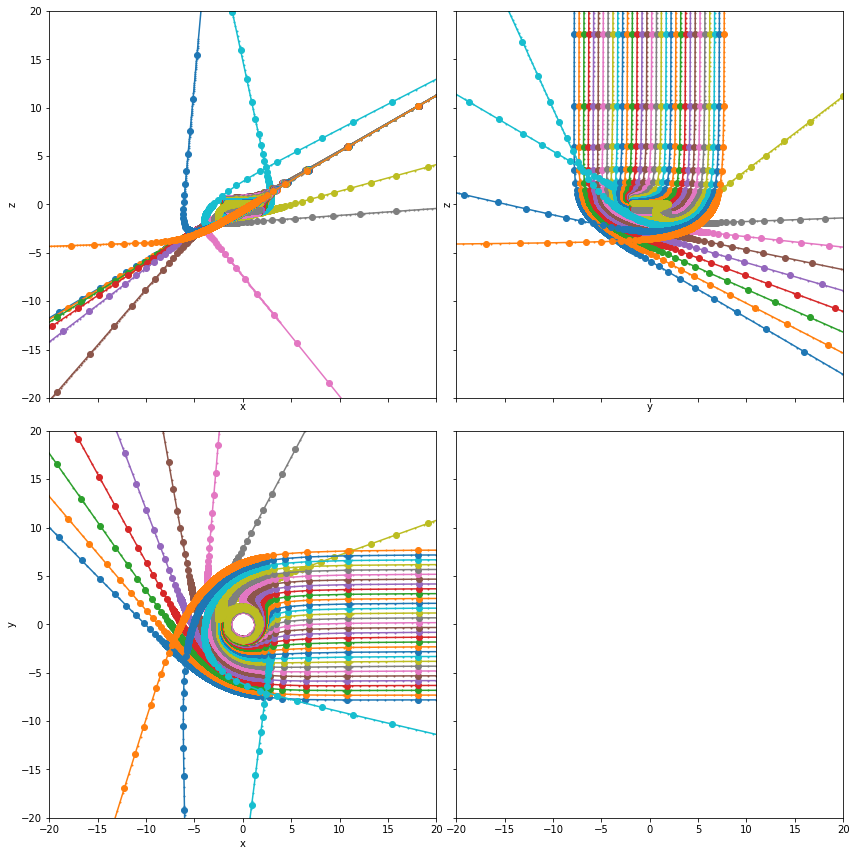

In [9]:
fig, axes = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)

for i,j in product(range(32), range(15,16)):
    axes[0][0].plot(fx[:,i,j], fz[:,i,j], '-o', color=f'C{i}')
    axes[0][1].plot(fy[:,i,j], fz[:,i,j], '-o', color=f'C{i}')
    axes[1][0].plot(fx[:,i,j], fy[:,i,j], '-o', color=f'C{i}')
    axes[0][0].scatter(ix[:,i,j], iz[:,i,j], s=1, color=f'C{i}')
    axes[0][1].scatter(iy[:,i,j], iz[:,i,j], s=1, color=f'C{i}')
    axes[1][0].scatter(ix[:,i,j], iy[:,i,j], s=1, color=f'C{i}')

fig.tight_layout()

ax = axes[0][0]
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

ax = axes[0][1]
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

ax = axes[1][0]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

ax = axes[1][1]
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

Here we zoom in and show only the geodesics that reach the horizon.

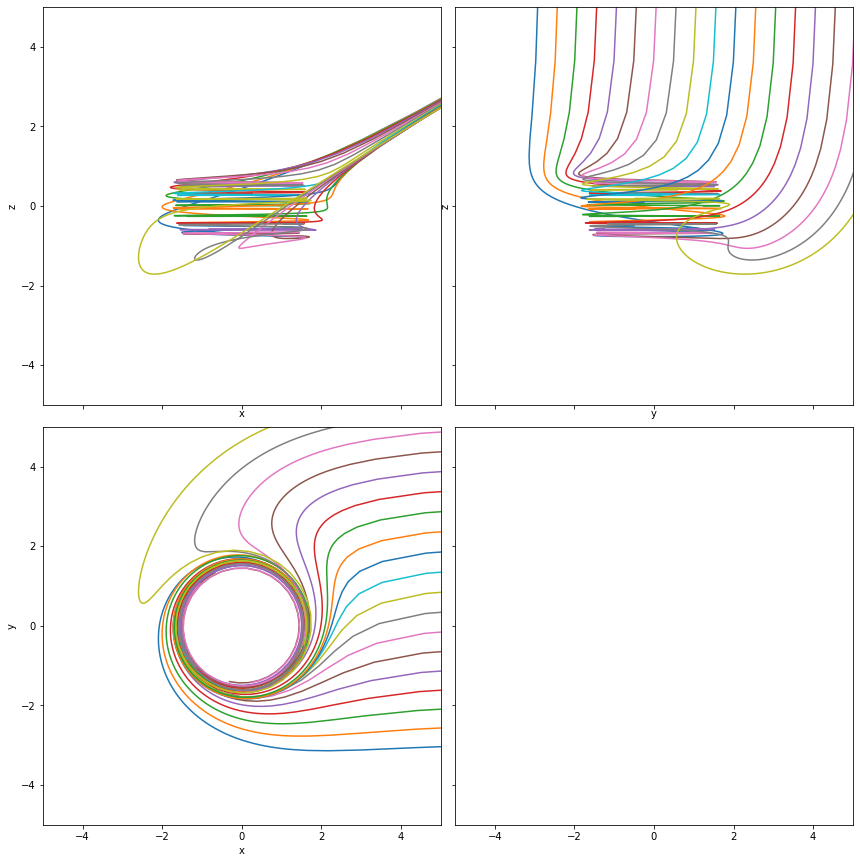

In [10]:
fig, axes = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)

for i,j in product(range(10,29), range(15,16)):
    axes[0][0].plot(fx[:,i,j], fz[:,i,j], '-', color=f'C{i}')
    axes[0][1].plot(fy[:,i,j], fz[:,i,j], '-', color=f'C{i}')
    axes[1][0].plot(fx[:,i,j], fy[:,i,j], '-', color=f'C{i}')

fig.tight_layout()

ax = axes[0][0]
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')

ax = axes[0][1]
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')

ax = axes[1][0]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')

ax = axes[1][1]
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')